In [ ]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install PyCRS
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.3

In [ ]:
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
from tqdm.autonotebook import tqdm
import os
from rasterio import windows as wind
from fiona.crs import from_epsg
from gis_utils import raster
import matplotlib.pyplot as plt
import fiona
import numpy as np

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.2.0
Hub version: 0.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Function for getting files needed for data generation process from the drive
from os.path import join

def get_filelist():
    cur = []
    dest = "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Training Images/Hybrid CNN/"

    #horrible search method, do not do this, only works because how we specifically set up the drive structure

    #iterating through all files in orthomosaics directory
    for root, dirs, files in os.walk("/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/"):
        for file in files:
            
            #finding all normal tifs
            if not(("dem" in file) or ("DEM" in file) or ("downsampled" in file) or ("CNN_prob" in file) or ("planetscope" in file)) and not(file.startswith("un_")) and not(file.endswith("CNN_nm.tif")) and not(file.endswith("CNN_m.tif")) and not(file.startswith("prob_"))  and  (file.endswith(".tif")):
                #detecting planetscope images
                for ortho in os.listdir(root):
                    if ("planetscope" in ortho):

                        #get shapefiles from classifications folder
                        for subroot, subdirs, subfiles in os.walk(root):
                            zero = "0.shp"
                            one = "1.shp"

                            #iterating through files in 
                            for subfile in subfiles:
                                if (subfile == zero) or (subfile == one):
                                    dest_zip = join(dest,os.path.splitext(file)[0] + ".zip")
                                    #since we will get dupicates
                                    file_list = [join(root,file),
                                                    join(root,ortho),
                                                    join(subroot,zero),
                                                    join(subroot,one),
                                                    dest_zip]
                                    if not(file_list in cur):
                                        cur.append(file_list)
                                    



    return cur

In [ ]:
#for clipping raster files

def clip(shp_file, image_file, str_format):
    with fiona.open(shp_file, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(image_file) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    with rasterio.open(str_format + image_file, "w", **out_meta) as dest:
        dest.write(out_image)

In [ ]:
# for copying files over from google drive to 
def copy_files(file_list):
    print("Copying Files")

    !cp {"\"" + file_list[0] + "\"" } .
    !cp {"\"" + file_list[1] + "\"" } .

    d_name = os.path.basename(file_list[0])
    p_name = os.path.basename(file_list[1])

    !mv {d_name} /content/drone.tif
    !mv {p_name} /content/planetscope.tif

    !rm -rf /content/0/
    !rm -rf /content/1/ 

    !rm -rf /content/0_hr/
    !rm -rf /content/1_hr/

    !mkdir 0
    !mkdir 1
    !mkdir 0_hr
    !mkdir 1_hr

In [ ]:
def clip_retile(file_list, width):
    print("Clipping and pixelizing satellite data")

    d_img, d_meta = raster.load_image("/content/drone.tif")
    zero_gpd = gpd.read_file(file_list[2])
    one_gpd = gpd.read_file(file_list[3])

    
    clip(file_list[2], "drone.tif", "clipped0_")
    clip(file_list[3], "drone.tif", "clipped1_")

    !gdal_retile.py -ps {width} {width} -targetDir "/content/0" "clipped0_drone.tif"
    !gdal_retile.py -ps {width} {width} -targetDir "/content/1" "clipped1_drone.tif"

    remove_zero("/content/0/")
    remove_zero("/content/1/")

In [ ]:
#for removing tiles created 
def remove_zero(img_dir):
    for filename in tqdm(os.listdir(img_dir)):
        filepath = os.path.join(img_dir, filename)
        tile, meta = raster.load_image(filepath)
        if np.array_equal(np.unique(np.array(tile.read())), [0.]):
            os.remove(filepath)

In [ ]:
def transfer_tiles(img, meta, tile_path, output_path):
    out_meta = meta
    output_filename = 'lr_{}.tif'
    d_bbox = box(img.bounds.left, img.bounds.bottom, img.bounds.right, img.bounds.top)

    for root, dirs, files in os.walk(tile_path):
        for file in tqdm(files):
            name = os.path.splitext(file)[0]
            dataset, _ = raster.load_image(join(root,file))
            bounds = dataset.bounds
            bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

            if bbox.within(d_bbox):
                geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
                geo = geo.to_crs(crs=dataset.crs.data)
                coords = getFeatures(geo)
                out_img, out_transform = mask(img, shapes=coords, crop=True)
                out_meta.update({"driver": "GTiff",
                        "height": out_img.shape[0],
                        "width": out_img.shape[1],
                        "transform": out_transform, 
                        "crs": from_epsg(4326)})
                outpath = os.path.join(output_path, output_filename.format(name))
                with rasterio.open(outpath, 'w', **out_meta) as outds:
                    outds.write(out_img)
            

In [ ]:
#for removing tiles created 
def show_pixels(img_dir):
    for filename in tqdm(os.listdir(img_dir)):
        filepath = os.path.join(img_dir, filename)
        tile, out_meta = raster.load_image(filepath)
    return tile, filepath
        

In [ ]:
sites = get_filelist()    

In [ ]:
site = sites[0]
copy_files(site)

Copying Files


In [ ]:
#getting features from the gdf for rasterio
from os.path import join

def getFeatures(gdf):

    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
width = 128


file_list = site

d_img, d_meta = raster.load_image("/content/drone.tif")
zero_gpd = gpd.read_file(file_list[2])
one_gpd = gpd.read_file(file_list[3])


clip(file_list[2], "drone.tif", "clipped0_")
clip(file_list[3], "drone.tif", "clipped1_")

!gdal_retile.py -ps {width} {width} -targetDir "/content/0_hr" "clipped0_drone.tif"
!gdal_retile.py -ps {width} {width} -targetDir "/content/1_hr" "clipped1_drone.tif"

remove_zero("/content/0_hr/")
remove_zero("/content/1_hr/")

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
p_img, p_meta = raster.load_image("/content/planetscope.tif")
    
transfer_tiles(p_img, p_meta, "/content/1_hr", "/content/1")
transfer_tiles(p_img, p_meta, "/content/0_hr", "/content/0")

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
import scipy.stats
from rasterio.plot import reshape_as_raster, reshape_as_image

tile, name = show_pixels("/content/1")
array = tile.read()

n_bands= 4




In [ ]:
!ls 0

lr_clipped0_drone_01_31.tif  lr_clipped0_drone_40_84.tif
lr_clipped0_drone_01_32.tif  lr_clipped0_drone_40_85.tif
lr_clipped0_drone_01_33.tif  lr_clipped0_drone_40_86.tif
lr_clipped0_drone_01_35.tif  lr_clipped0_drone_41_36.tif
lr_clipped0_drone_02_30.tif  lr_clipped0_drone_41_37.tif
lr_clipped0_drone_02_31.tif  lr_clipped0_drone_41_38.tif
lr_clipped0_drone_02_32.tif  lr_clipped0_drone_41_39.tif
lr_clipped0_drone_02_33.tif  lr_clipped0_drone_41_40.tif
lr_clipped0_drone_02_34.tif  lr_clipped0_drone_41_41.tif
lr_clipped0_drone_02_35.tif  lr_clipped0_drone_41_42.tif
lr_clipped0_drone_02_36.tif  lr_clipped0_drone_41_44.tif
lr_clipped0_drone_03_29.tif  lr_clipped0_drone_41_45.tif
lr_clipped0_drone_03_30.tif  lr_clipped0_drone_41_46.tif
lr_clipped0_drone_03_31.tif  lr_clipped0_drone_41_47.tif
lr_clipped0_drone_03_32.tif  lr_clipped0_drone_41_48.tif
lr_clipped0_drone_03_33.tif  lr_clipped0_drone_41_49.tif
lr_clipped0_drone_03_34.tif  lr_clipped0_drone_41_50.tif
lr_clipped0_drone_03_35.tif  lr

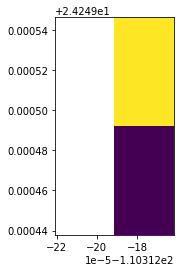

In [ ]:
image, _ = raster.load_image("0/lr_clipped0_drone_39_86.tif")
show(image)

In [ ]:
array.shape

(4, 3, 4)